# Regression - Optimize and save models

In the previous notebook, we used complex regression models to look at the relationship between features of a bike rentals dataset. In this notebook, we'll see if we can improve the performance of these models even further.

Let's start by loading the bicycle sharing data as a **Pandas** DataFrame and viewing the first few rows. As usual, we'll also split our data into training and test datasets.

In [1]:
# Import modules we'll need for this notebook
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load the training dataset
bike_data = pd.read_csv('daily-bike-share.csv')
bike_data['day'] = pd.DatetimeIndex(bike_data['dteday']).day
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit', 'day']
bike_data[numeric_features + ['rentals']].describe()
print(bike_data.head())


# Separate features and labels
# After separating the dataset, we now have numpy arrays named **X** containing the features, and **y** containing the labels.
X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))


   instant    dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  1/1/2011       1   0     1        0        6           0   
1        2  1/2/2011       1   0     1        0        0           0   
2        3  1/3/2011       1   0     1        0        1           1   
3        4  1/4/2011       1   0     1        0        2           1   
4        5  1/5/2011       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  rentals  day  
0           2  0.344167  0.363625  0.805833   0.160446      331    1  
1           2  0.363478  0.353739  0.696087   0.248539      131    2  
2           1  0.196364  0.189405  0.437273   0.248309      120    3  
3           1  0.200000  0.212122  0.590435   0.160296      108    4  
4           1  0.226957  0.229270  0.436957   0.186900       82    5  
Training Set: 511 rows
Test Set: 220 rows


Now we have the following four datasets:

- **X_train**: The feature values we'll use to train the model
- **y_train**: The corresponding labels we'll use to train the model
- **X_test**: The feature values we'll use to validate the model
- **y_test**: The corresponding labels we'll use to validate the model

Now we're ready to train a model by fitting a *boosting* ensemble algorithm, as in our last notebook. Recall that a Gradient Boosting estimator is like a Random Forest algorithm, but instead of building all trees independently and taking the average result, each tree is built on the outputs of the previous one in an attempt to incrementally reduce the *loss* (error) in the model.

GradientBoostingRegressor() 

MSE: 104186.02807871229
RMSE: 322.77860536087627
R2: 0.7957498310463221


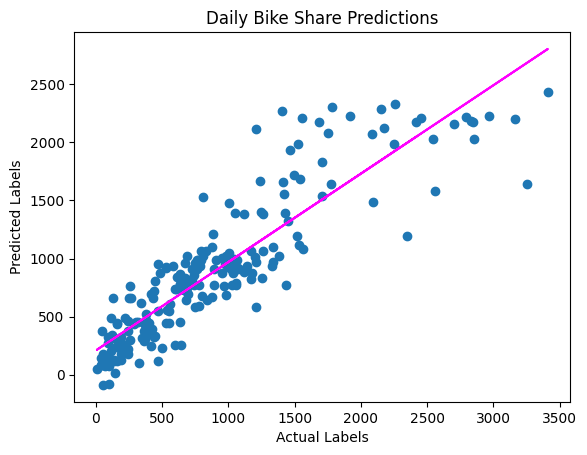

In [2]:
# Train the model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


# Fit a lasso model on the training set
model = GradientBoostingRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Optimize Hyperparameters

Take a look at the **GradientBoostingRegressor** estimator definition in the preceding output and note that it, like the other estimators we tried previously, includes a large number of parameters that control the way the model is trained. In machine learning, the term *parameters* refers to values that can be determined from data; values that you specify to affect the behavior of a training algorithm are more correctly referred to as *hyperparameters*.

The specific hyperparameters for an estimator vary based on the algorithm that the estimator encapsulates. In the case of the **GradientBoostingRegressor** estimator, the algorithm is an ensemble that combines multiple decision trees to create an overall predictive model. You can learn about the hyperparameters for this estimator in the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).

We won't go into the details of each hyperparameter here, but they work together to affect the way the algorithm trains a model. In many cases, the default values provided by Scikit-Learn will work well, but there could be some advantage in modifying hyperparameters to get better predictive performance or reduce training time.

So how do you know what hyperparameter values you should use? Well, in the absence of a deep understanding of how the underlying algorithm works, you'll need to experiment. Fortunately, SciKit-Learn provides a way to *tune* hyperparameters by trying multiple combinations and finding the best result for a given performance metric.

Let's try using a *grid search* approach to try combinations from a grid of possible values for the **learning_rate** and **n_estimators** hyperparameters of the **GradientBoostingRegressor** estimator.

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 100} 

GradientBoostingRegressor() 

MSE: 103862.3089620442
RMSE: 322.2767583336475
R2: 0.796384462056759


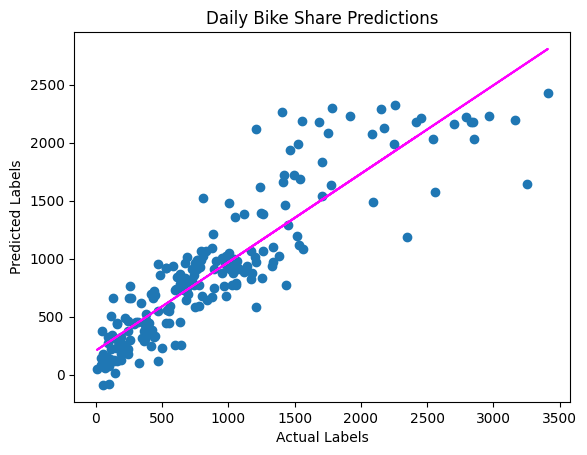

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

> **Note**: The use of random values in the Gradient Boosting algorithm results in slightly different metrics each time. In this case, the best model produced by hyperparameter tuning is unlikely to be significantly better than one trained with the default hyperparameter values; but it's still useful to know about the hyperparameter tuning technique!

## Preprocess the Data

We trained a model with data that we loaded straight from a source file, with only moderately successful results.

In practice, it's common to perform some preprocessing of the data to make it easier for the algorithm to fit a model to it. There's a huge range of preprocessing transformations you can perform to get your data ready for modeling, but we'll limit ourselves to a few common techniques:

### Scaling numeric features

Normalizing numeric features so they're on the same scale prevents features with large values from producing coefficients that disproportionately affect the predictions. For example, suppose your data includes the following numeric features:

| A |  B  |  C  |
| - | --- | --- |
| 3 | 480 | 65  |
    
Normalizing these features to the same scale may result in the following values (assuming A contains values from 0 to 10, B contains values from 0 to 1000, and C contains values from 0 to 100):

|  A  |  B  |  C  |
| --  | --- | --- |
| 0.3 | 0.48| 0.65|

There are multiple ways you can scale numeric data, such as calculating the minimum and maximum values for each column and assigning a proportional value between 0 and 1, or by using the mean and standard deviation of a normally distributed variable to maintain the same *spread* of values on a different scale.

### Encoding categorical variables

Machine-learning models work best with numeric features rather than text values, so you generally need to convert categorical features into numeric representations. For example, suppose your data includes the following categorical feature:

| Size |
| ---- |
|  S   |
|  M   |
|  L   |

You can apply *ordinal encoding* to substitute a unique integer value for each category, like this:

| Size |
| ---- |
|  0   |
|  1   |
|  2   |

Another common technique is to use *one-hot encoding* to create individual binary (0 or 1) features for each possible category value. For example, you could use one-hot encoding to translate the possible categories into binary columns like this:

|  Size_S  |  Size_M  |  Size_L  |
| -------  | -------- | -------- |
|    1     |     0    |    0     |
|    0     |     1    |    0     |
|    0     |     0    |    1     |

To apply these preprocessing transformations to the bike rental, we'll make use of a Scikit-Learn feature named *pipelines*. These pipelines allow us to define a set of preprocessing steps that end with an algorithm. You can then fit the entire pipeline to the data, so that the model encapsulates all of the preprocessing steps as well as the regression algorithm. This is useful, because when we want to use the model to predict values from new data, we need to apply the same transformations (based on the same statistical distributions and category encodings used with the training data).

>**Note**: The term *pipeline* is used extensively in machine learning, often to mean very different things! In this context, we're using it to refer to pipeline objects in Scikit-Learn, but you might see it used elsewhere to mean something else.

In [4]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [6,7,8,9]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [0,1,2,3,4,5]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', GradientBoostingRegressor())])


OK, the model is trained, including the preprocessing steps. Let's see how it performs with the validation data.

MSE: 105681.97251634976
RMSE: 325.0876382090678
R2: 0.7928171258672561


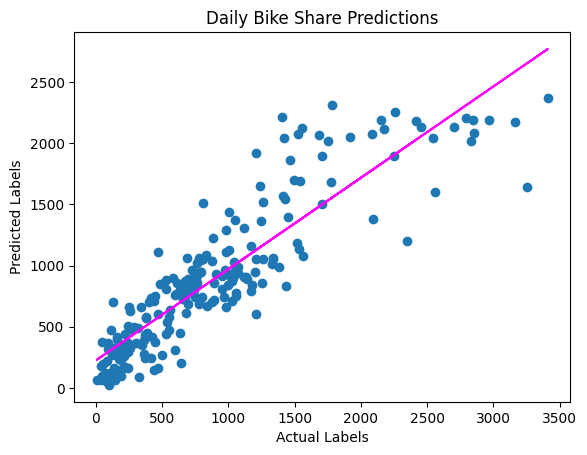

In [5]:
# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

The pipeline is composed of the transformations and the algorithm used to train the model. To try an alternative algorithm, you can just change that step to a different kind of estimator.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', RandomForestRegressor())]) 

MSE: 108445.64526954548
RMSE: 329.31086418389765
R2: 0.7873991188927849


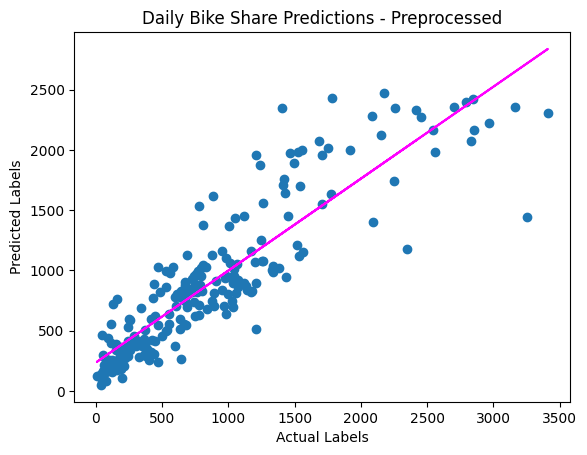

In [6]:
# Use a different estimator in the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model, "\n")

# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions - Preprocessed')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

We've now seen a number of common techniques used to train predictive models for regression. In a real project, you'd likely try a few more algorithms, hyperparameters, and preprocessing transformations; but by now, you should have gotten the general idea. Let's explore how you can use the trained model with new data.

### Use the Trained Model

First, let's save the model.

In [8]:
import joblib

# Save the model as a pickle file
filename = './bike-share.pkl'
joblib.dump(model, filename)

['./bike-share.pkl']

Now, we can load it whenever we need it and use it to predict labels for new data. This is often called *scoring* or *inferencing*.

In [9]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[1,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} rentals'.format(np.round(result[0])))

New sample: [1.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.226957, 0.22927, 0.436957, 0.1869]
Prediction: 110 rentals


The model's **predict** method accepts an array of observations, so you can use it to generate multiple predictions as a batch. For example, suppose you have a weather forecast for the next five days; you could use the model to predict bike rentals for each day based on the expected weather conditions.

In [10]:
# An array of features based on five-day weather forecast
X_new = np.array([[0,1,1,0,0,1,0.344167,0.363625,0.805833,0.160446],
                  [0,1,0,1,0,1,0.363478,0.353739,0.696087,0.248539],
                  [0,1,0,2,0,1,0.196364,0.189405,0.437273,0.248309],
                  [0,1,0,3,0,1,0.2,0.212122,0.590435,0.160296],
                  [0,1,0,4,0,1,0.226957,0.22927,0.436957,0.1869]])

# Use the model to predict rentals
results = loaded_model.predict(X_new)
print('5-day rental predictions:')
for prediction in results:
    print(np.round(prediction))

5-day rental predictions:
548.0
770.0
252.0
195.0
277.0


## Summary

This concludes the notebooks for this module on regression. In this notebook, we ran a complex regression, tuned it, saved the model, and used it to predict outcomes for the future.

## Further Reading

To learn more about Scikit-Learn, see the [Scikit-Learn documentation](https://scikit-learn.org/stable/user_guide.html).
